# Preprocessing

In [ ]:
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
import re
import json
import spacy

with open('stopwords-iso.json', 'r', encoding='utf-8') as file:
    stopwords_iso = json.load(file)

stopwords = set(nltk_stopwords.words('english'))
custom_stopwords = set(['server', 'joined', 'scroll', 'papyri', 'image', 'brett', 'olsen', 'entry', 'start', 'thread', 'moshe', 'levy', 'casey', 'handmer', 'mae', 'sawatzky'])
stopwords.update(custom_stopwords)
stopwords.update(stopwords_iso['en'])

def preprocess_text(text):

    # Convert text to lowercase
    text = text.lower()
    
    # Load SpaCy model
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    # Lemmatize and lowercase each token
    text = ' '.join([token.lemma_.lower() for token in doc])
    
    # Remove function definitions
    text = re.sub(r'\b[a-zA-Z_][a-zA-Z0-9_]*\s*\([^)]*\)\s*', '', text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove file names with common extensions
    text = re.sub(r'\b\w+\.(zip|tif|pdf|jpg|png|docx|xlsx|rar|txt|csv|json)\b', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove special characters and emojis
    text = re.sub(r'[\U0001F600-\U0001F64F'
              r'\U0001F300-\U0001F5FF'  
              r'\U0001F680-\U0001F6FF'  
              r'\U0001F700-\U0001F77F'  
              r'\U0001F780-\U0001F7FF'  
              r'\U0001F800-\U0001F8FF'  
              r'\U0001F900-\U0001F9FF'  
              r'\U0001FA00-\U0001FA6F'  
              r'\U0001FA70-\U0001FAFF'  
              r'\u2600-\u26FF'          
              r'\u2700-\u27BF'       
              ']+', '', text)

    # Remove stopwords
    tokens = text.split()
    tokens = [token for token in tokens if token not in stopwords]
    
    return ' '.join(tokens)

def preprocess_json(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    for message in data.get('messages', []):
        if message.get('content'):
            message['content'] = preprocess_text(message['content'])

    with open(output_file, 'w', encoding='utf-8') as file:
        json.dump(data, file, indent=4)

    print(f'Preprocessed data has been saved to {output_file}')

 
def preprocess_all_files(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        input_file = os.path.join(input_folder, filename)
        output_file = os.path.join(output_folder, filename)
        preprocess_json(input_file, output_file)


input_folder = 'filteredJSON'
output_folder = 'preprocessedJSON'

preprocess_all_files(input_folder, output_folder)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\summerm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessed data has been saved to preprocessedJSON\Vesuvius Challenge - code - 3D FFT [1165255454037917797]_filtered.json
Preprocessed data has been saved to preprocessedJSON\Vesuvius Challenge - code - Code tip_ mirror the data server directory structure locally [1162854815731306666]_filtered.json
Preprocessed data has been saved to preprocessedJSON\Vesuvius Challenge - code - Colab recommendation for persistent storage_ [1163820413621633124]_filtered.json
Preprocessed data has been saved to preprocessedJSON\Vesuvius Challenge - code - Constraint solvers for bruteforcing missing_ambiguous letters [1163049828721369118]_filtered.json
Preprocessed data has been saved to preprocessedJSON\Vesuvius Challenge - code - Permission denied when sshing from paperspace machine (web browser works okay) [1163661867185606737]_filtered.json
Preprocessed data has been saved to preprocessedJSON\Vesuvius Challenge - code - Speed-check your image loading [1164605201408348251]_filtered.json
Preprocessed 

In [53]:
# Additional stopword cleanup for when new ones need to be added so we don't have to reprocess everything
additional_stopwords = set(['mae', 'sawatzky'])  # Add any new terms here
input_folder = 'preprocessedJSON'
output_folder = 'preprocessedJSON'

def remove_additional_stopwords(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        input_file = os.path.join(input_folder, filename)
        output_file = os.path.join(output_folder, filename)

        with open(input_file, 'r', encoding='utf-8') as file:
            data = json.load(file)

        for message in data.get('messages', []):
            if message.get('content'):
                tokens = message['content'].split()
                tokens = [token for token in tokens if token not in additional_stopwords]
                message['content'] = ' '.join(tokens)

        with open(output_file, 'w', encoding='utf-8') as file:
            json.dump(data, file, indent=4)

        print(f'Additional stopwords removed from {filename}')

remove_additional_stopwords(input_folder, output_folder)


Additional stopwords removed from Vesuvius Challenge - code - 3D FFT [1165255454037917797]_filtered.json
Additional stopwords removed from Vesuvius Challenge - code - Code tip_ mirror the data server directory structure locally [1162854815731306666]_filtered.json
Additional stopwords removed from Vesuvius Challenge - code - Colab recommendation for persistent storage_ [1163820413621633124]_filtered.json
Additional stopwords removed from Vesuvius Challenge - code - Constraint solvers for bruteforcing missing_ambiguous letters [1163049828721369118]_filtered.json
Additional stopwords removed from Vesuvius Challenge - code - Permission denied when sshing from paperspace machine (web browser works okay) [1163661867185606737]_filtered.json
Additional stopwords removed from Vesuvius Challenge - code - Speed-check your image loading [1164605201408348251]_filtered.json
Additional stopwords removed from Vesuvius Challenge - code - VC Build errors [1165426438061690880]_filtered.json
Additional st

# Organizing Messages

In [54]:
import pandas as pd
input_folder = 'preprocessedJSON'
def get_all_documents(folder):
    all_docs = []
    files =  {'Vesuvius Challenge - Text Channels - papyrology [1108134343295127592]_filtered.json', 
              'Vesuvius Challenge - Text Channels - general [1079907750265499772]_filtered.json'} #for looking at specific files, can customize

    for fname in os.listdir(folder):
        if fname not in files:
            continue

        with open(os.path.join(folder, fname), 'r', encoding='utf-8') as f:
            data = json.load(f)
            channel = data.get("channel", "Unknown")
            channel_name = channel.get("name") if isinstance(channel, dict) else channel

            for msg in data.get("messages", []):
                content = msg.get("content", "")
                if content.strip():  # Only include non-empty messages
                    all_docs.append({
                        "channel": channel_name,
                        "user": msg.get("author", {}).get("name", "Unknown"),
                        "timestamp": msg.get("timestamp", "Unknown"),
                        "content": content
                    })

    return all_docs


df = pd.DataFrame(get_all_documents(input_folder))

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
# Remove timezone only if present
if df['timestamp'].dt.tz is not None:
    df['timestamp'] = df['timestamp'].dt.tz_localize(None)


# Term Frequency

In [55]:
import pandas as pd
from collections import Counter
from nltk.util import ngrams
import spacy
import re
import unicodedata

# Load SpaCy model
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")


def is_greek_script(token_text):
    return any('GREEK' in unicodedata.name(c, '') for c in token_text)

def tokenize(text):
    doc = nlp(text.lower())
    tokens = []

    for token in doc:
        if token.is_alpha:
            if is_greek_script(token.text):
                tokens.append('[GREEK_LANGUAGE]')
            else:
                tokens.append(token.text)
    return tokens


df['tokens'] = df['content'].apply(tokenize)

# Compute term frequency and document frequency
def get_ngram_stats(token_lists, n=1):
    term_freq = Counter()
    doc_freq = Counter()

    for tokens in token_lists:
        if n == 1:
            terms = tokens
        else:
            terms = list(ngrams(tokens, n))

        term_freq.update(terms)
        doc_freq.update(set(terms))  # Count each term once per document

    return term_freq, doc_freq

# Convert stats to DataFrame
def ngram_df_with_stats(term_freq, doc_freq, label='ngram', top_k=50):
    df = pd.DataFrame({
        label: list(term_freq.keys()),
        'term_frequency': list(term_freq.values()),
        'document_frequency': [doc_freq[term] for term in term_freq]
    })
    df.sort_values(by='term_frequency', ascending=False, inplace=True)
    return df.head(top_k)


# Split by channel
general_msgs = df[df['channel'] == 'general']['tokens'].dropna().tolist()
papyrology_msgs = df[df['channel'] == 'papyrology']['tokens'].dropna().tolist()
combined_msgs = general_msgs + papyrology_msgs

# Get stats
tf_uni_comb, df_uni_comb = get_ngram_stats(combined_msgs, n=1)
tf_bi_comb, df_bi_comb = get_ngram_stats(combined_msgs, n=2)

tf_uni_gen, df_uni_gen = get_ngram_stats(general_msgs, n=1)
tf_uni_pap, df_uni_pap = get_ngram_stats(papyrology_msgs, n=1)

tf_bi_gen, df_bi_gen = get_ngram_stats(general_msgs, n=2)
tf_bi_pap, df_bi_pap = get_ngram_stats(papyrology_msgs, n=2)

# Write to Excel
with pd.ExcelWriter('channel_analysis3.xlsx') as writer:
    df.to_excel(writer, sheet_name='Messages', index=False)

    # Combined bigrams
    ngram_df_with_stats(tf_bi_comb, df_bi_comb, 'bigram').to_excel(writer, sheet_name='Bigrams Combined', index=False)

    # Separate bigrams
    pd.concat([
        ngram_df_with_stats(tf_bi_gen, df_bi_gen, 'bigram').assign(channel='general'),
        ngram_df_with_stats(tf_bi_pap, df_bi_pap, 'bigram').assign(channel='papyrology')
    ]).to_excel(writer, sheet_name='Bigrams Separate', index=False)

    # Combined unigrams
    ngram_df_with_stats(tf_uni_comb, df_uni_comb, 'unigram').to_excel(writer, sheet_name='Unigrams Combined', index=False)

    # Separate unigrams
    pd.concat([
        ngram_df_with_stats(tf_uni_gen, df_uni_gen, 'unigram').assign(channel='general'),
        ngram_df_with_stats(tf_uni_pap, df_uni_pap, 'unigram').assign(channel='papyrology')
    ]).to_excel(writer, sheet_name='Unigrams Separate', index=False)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Statistics


--- General Channel ---
Total messages: 5885


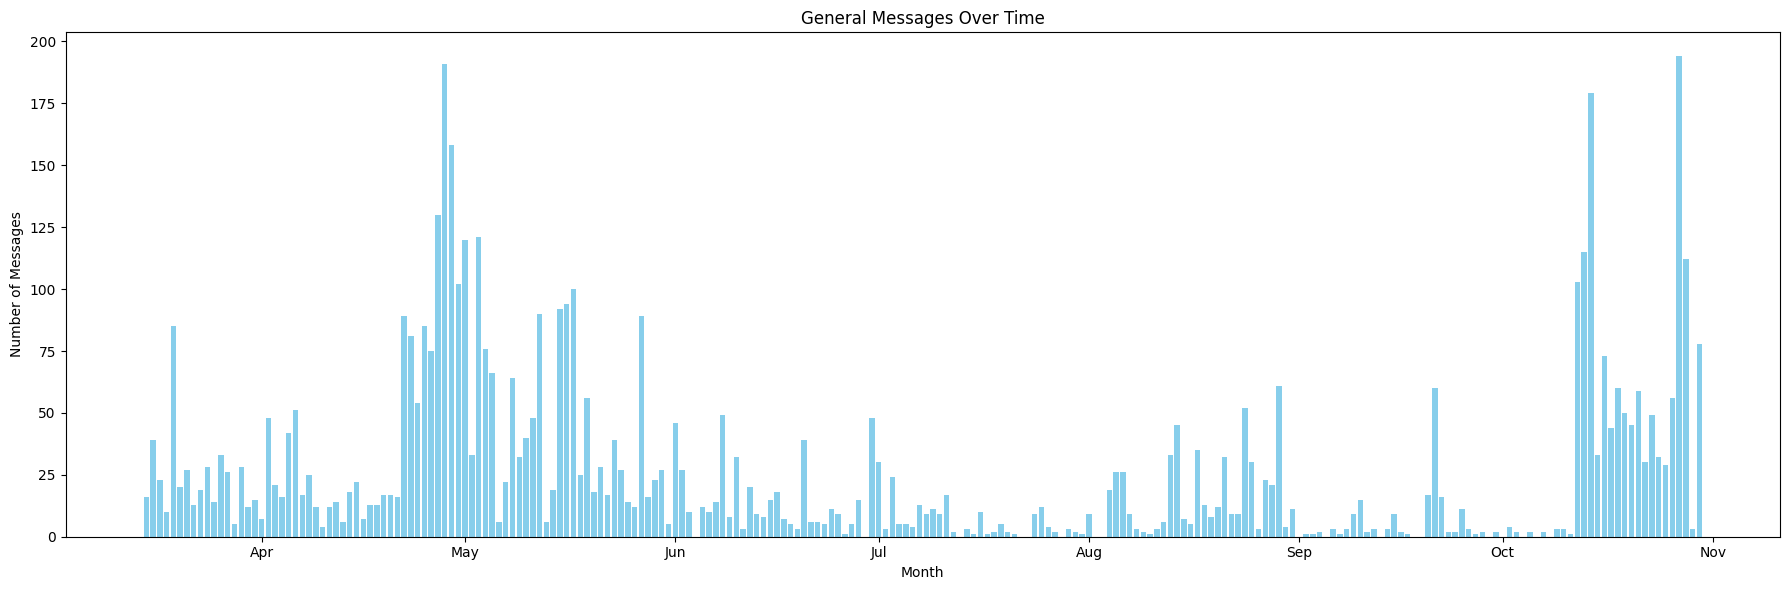

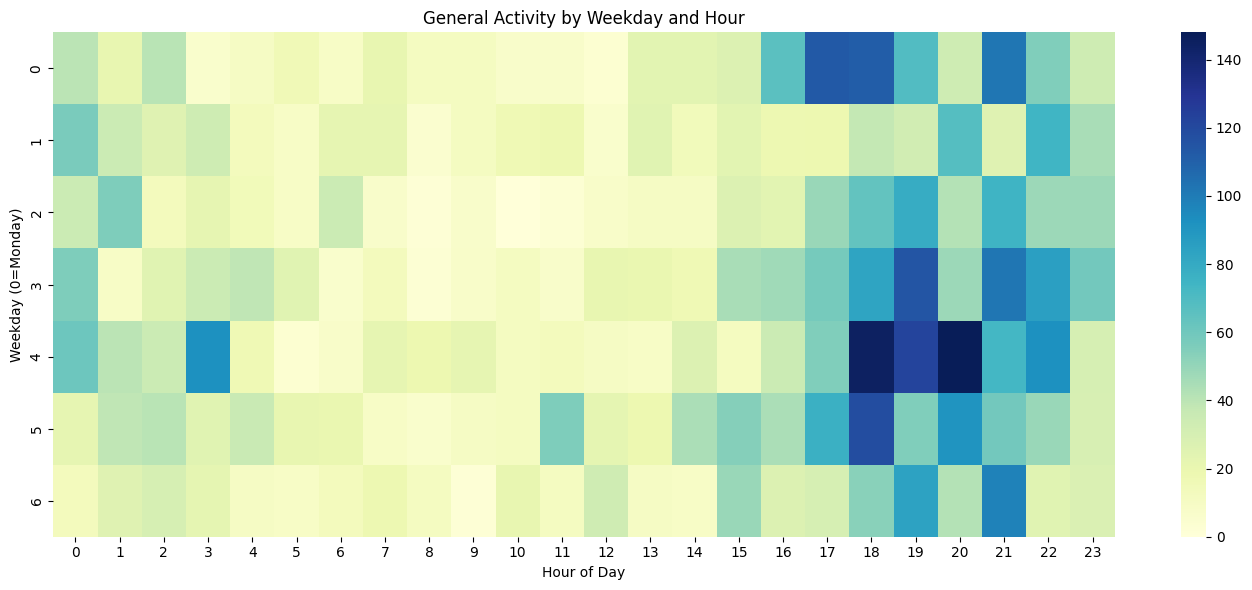

C:\Users\summerm\AppData\Local\Temp\ipykernel_27200\2524984162.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.values, y=top_users.index, palette='viridis')


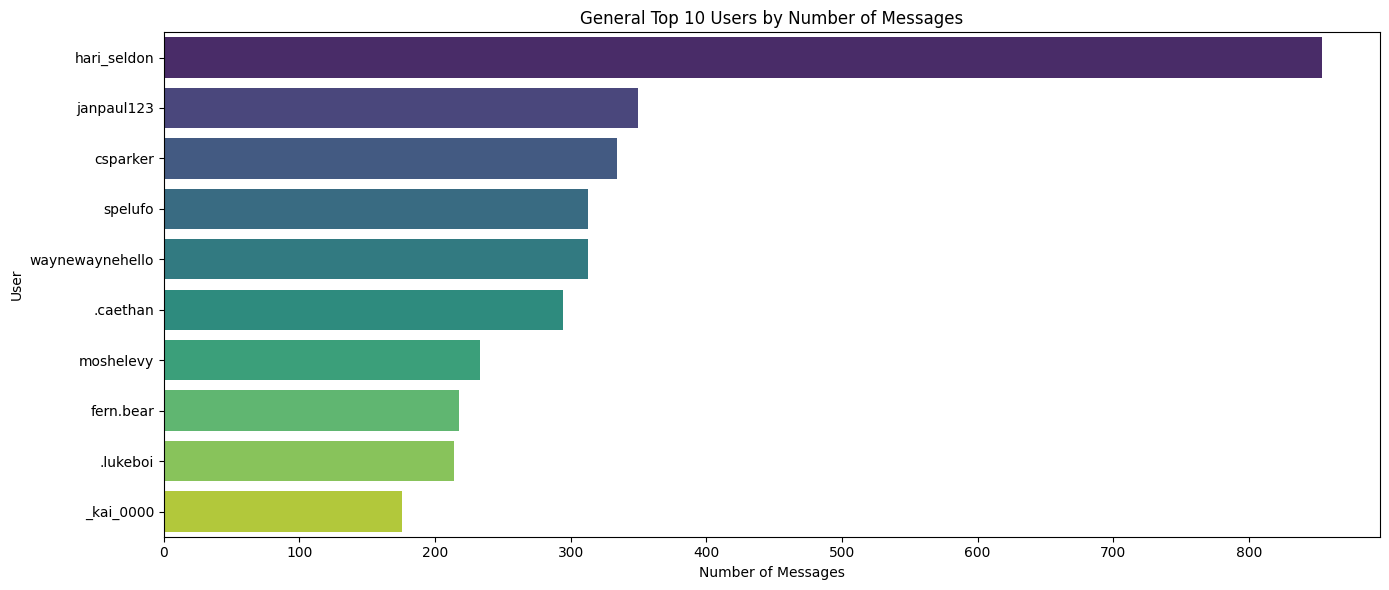


--- Papyrology Channel ---
Total messages: 1355


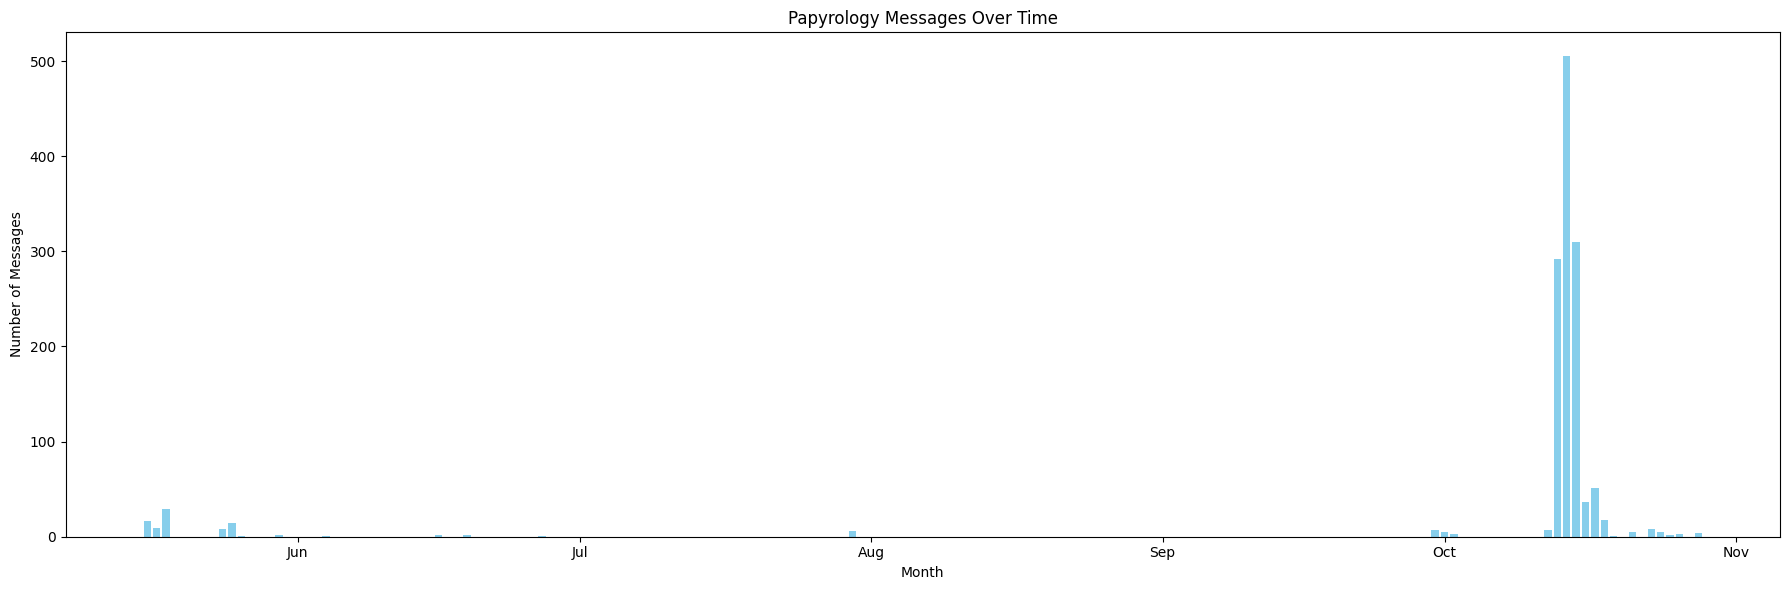

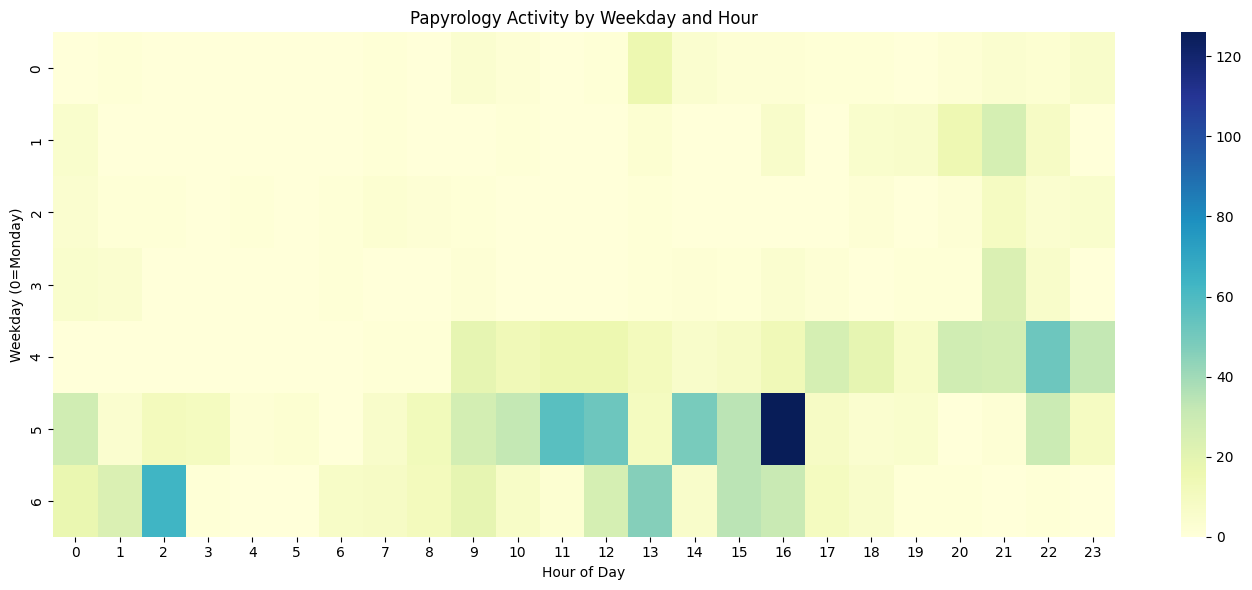

C:\Users\summerm\AppData\Local\Temp\ipykernel_27200\2524984162.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.values, y=top_users.index, palette='viridis')


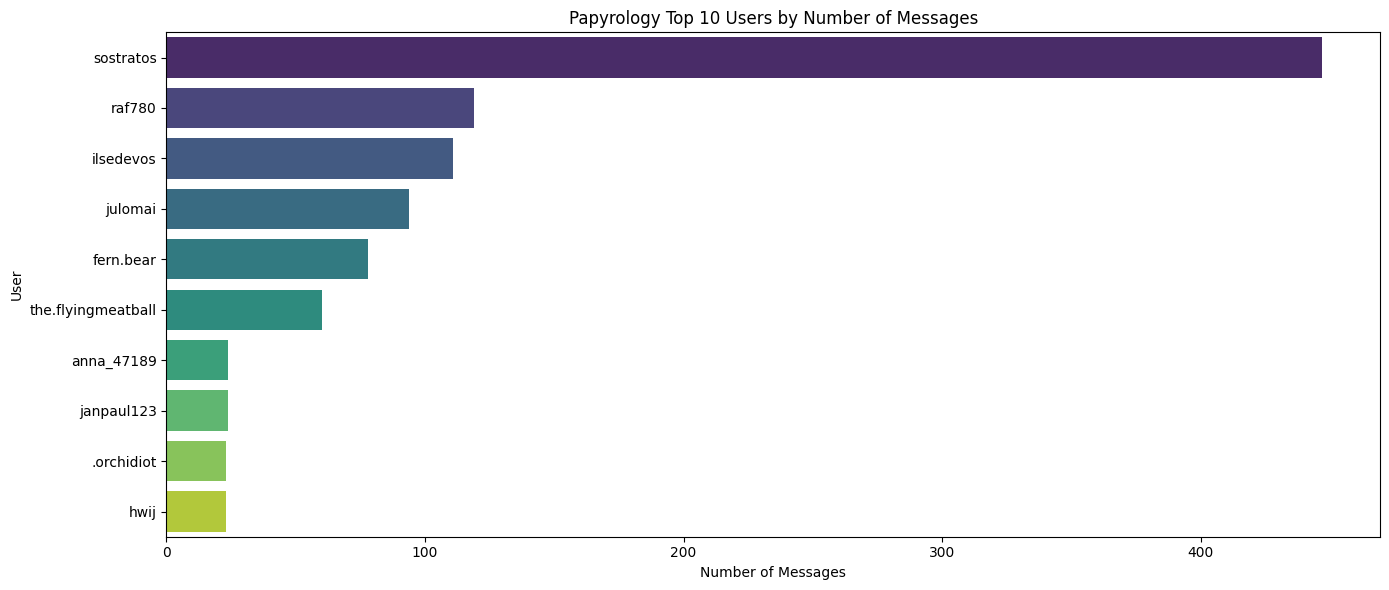


--- Both Channel ---
Total messages: 7240


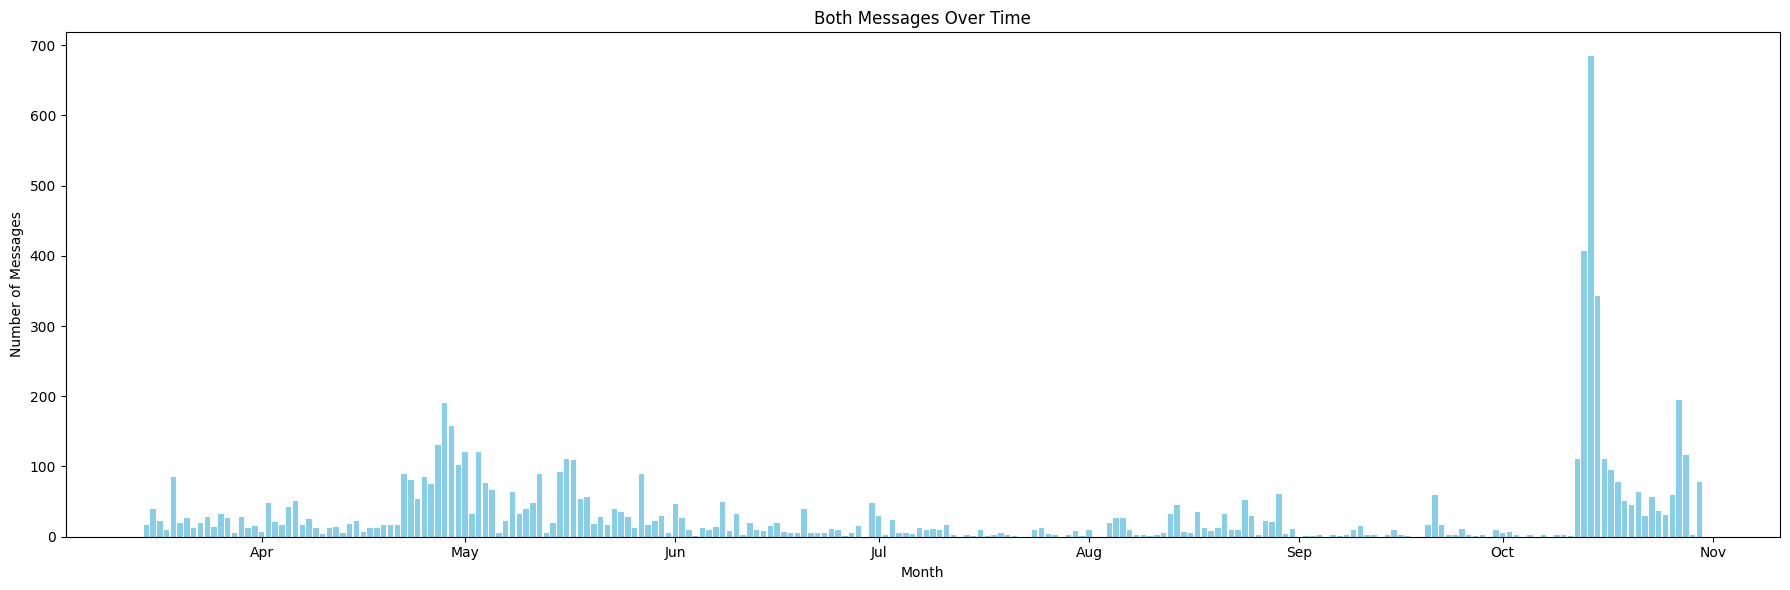

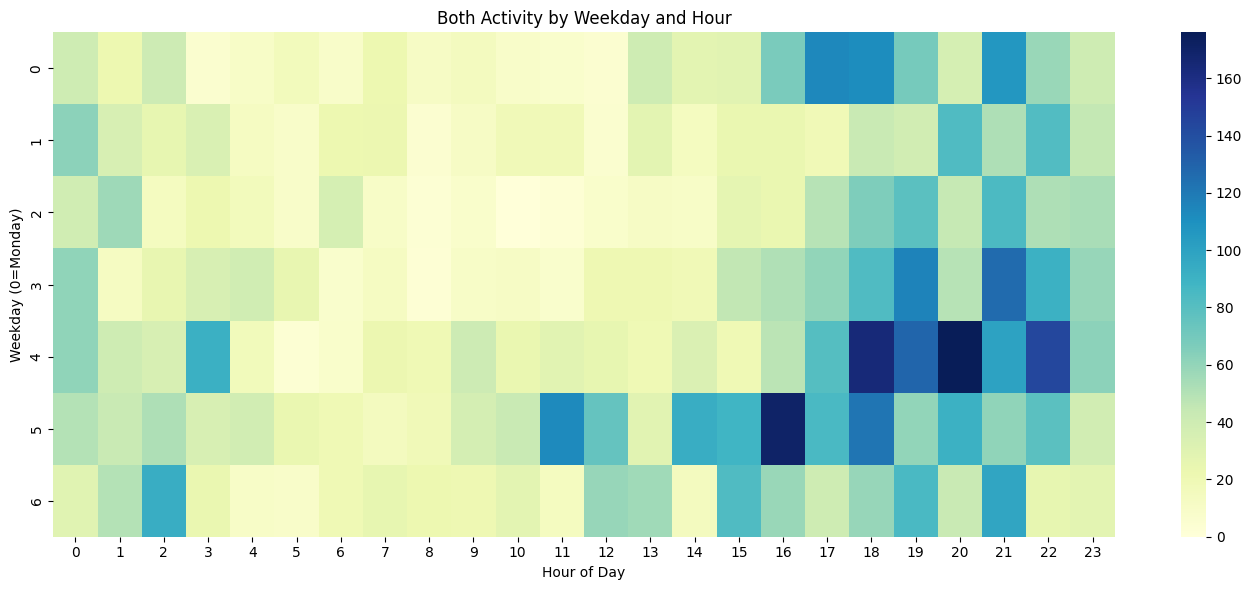

C:\Users\summerm\AppData\Local\Temp\ipykernel_27200\2524984162.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.values, y=top_users.index, palette='viridis')


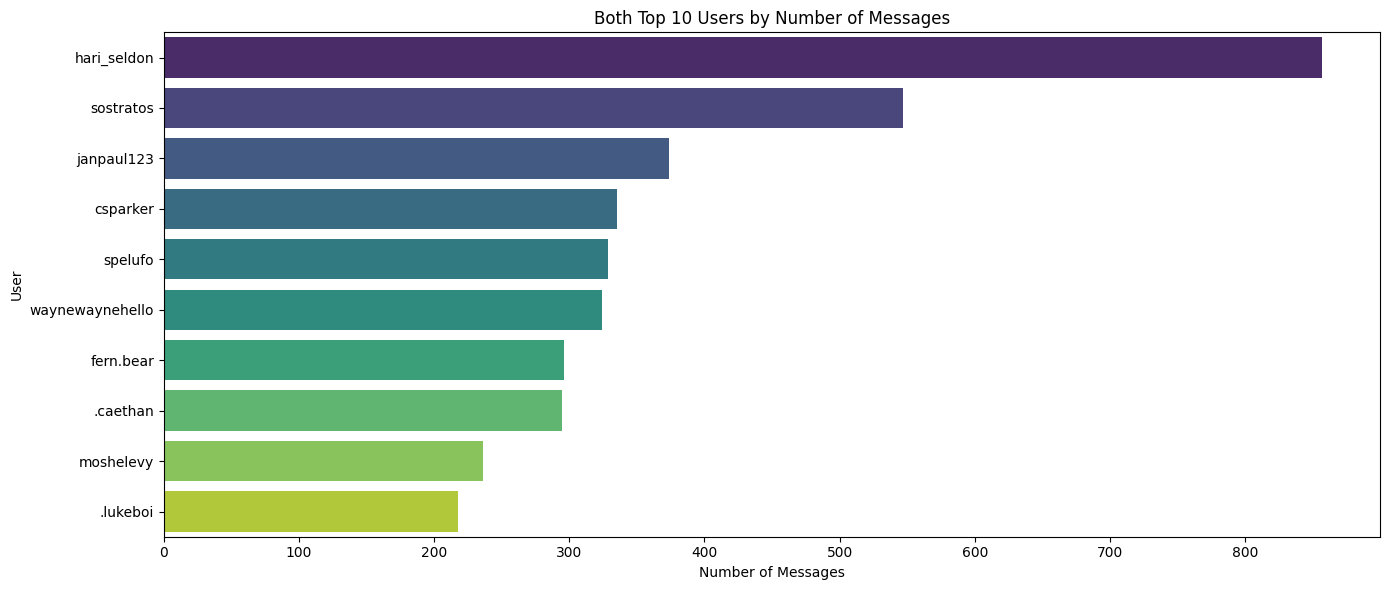

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Read in the dataframe
df = pd.read_excel('channel_analysis.xlsx', sheet_name='Messages')

# Normalize channel names
df['channel'] = df['channel'].str.lower()

# Define subsets
channels = {
    'General': df[df['channel'] == 'general'],
    'Papyrology': df[df['channel'] == 'papyrology'],
    'Both': df
}

# Loop through each subset
for name, subset in channels.items():
    print(f"\n--- {name} Channel ---")
    print(f"Total messages: {len(subset)}")

    # Convert timestamp and sort
    subset = subset.copy()
    subset['timestamp'] = pd.to_datetime(subset['timestamp'], errors='coerce')
    subset = subset.dropna(subset=['timestamp'])
    subset = subset.set_index('timestamp').sort_index()

    # Messages per day
    messages_per_day = subset.resample('D').size()

    # Reindex to include all days in range (even with zero messages)
    start_date = subset.index.min().normalize()
    end_date = subset.index.max().normalize()
    all_days = pd.date_range(start=start_date, end=end_date, freq='D')
    messages_per_day = messages_per_day.reindex(all_days, fill_value=0)

    # Plot with narrow bars and month labels
    plt.figure(figsize=(18, 6))
    plt.bar(messages_per_day.index, messages_per_day.values, width=0.8, color='skyblue')
    plt.title(f'{name} Messages Over Time')
    plt.xlabel('Month')
    plt.ylabel('Number of Messages')

    # Format x-axis to show month names
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    plt.tight_layout()
    plt.show()

    # Activity by weekday and hour
    subset['weekday'] = subset.index.weekday
    subset['hour'] = subset.index.hour
    activity = subset.groupby(['weekday', 'hour']).size().unstack(fill_value=0)

    plt.figure(figsize=(14, 6))
    sns.heatmap(activity, cmap='YlGnBu')
    plt.title(f'{name} Activity by Weekday and Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Weekday (0=Monday)')
    plt.tight_layout()
    plt.show()

    # Top users
    top_users = subset['user'].value_counts().head(10)
    plt.figure(figsize=(14, 6))
    sns.barplot(x=top_users.values, y=top_users.index, palette='viridis')
    plt.title(f'{name} Top 10 Users by Number of Messages')
    plt.xlabel('Number of Messages')
    plt.ylabel('User')
    plt.tight_layout()
    plt.show()